In [1]:
# load dependencies
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import model_evaluation_utils as meu
%matplotlib inline

# load saved models
tl_img_aug_finetune_cnn = load_model('dank_not_dank_tlearn_finetune_img_aug_cnn.h5')

# load other configurations
IMG_DIM = (299, 299)
input_shape = (299, 299, 3)
num2class_label_transformer = lambda l: ['dank' if x == 0 else 'not_dank' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'dank' else 1 for x in l]

# load VGG model for bottleneck features
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

Using TensorFlow backend.


In [2]:
IMG_DIM = (299, 299)

test_files = glob.glob('data/test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in test_files]

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255
test_labels_enc = class2num_label_transformer(test_labels)

print('Test dataset shape:', test_imgs.shape)
print(test_labels[0:5], test_labels_enc[0:5])

Test dataset shape: (948, 299, 299, 3)
['dank', 'dank', 'dank', 'dank', 'dank'] [0, 0, 0, 0, 0]


In [3]:
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

In [4]:
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.5802
Precision: 0.5874
Recall: 0.5802
F1 Score: 0.5713

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    not_dank       0.61      0.44      0.51       474
        dank       0.56      0.72      0.63       474

    accuracy                           0.58       948
   macro avg       0.59      0.58      0.57       948
weighted avg       0.59      0.58      0.57       948


Prediction Confusion Matrix:
------------------------------
                 Predicted:     
                   not_dank dank
Actual: not_dank        207  267
        dank            131  343


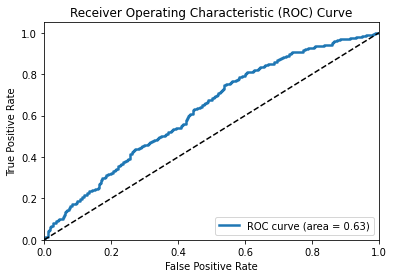

In [6]:
meu.plot_model_roc_curve(tl_img_aug_finetune_cnn, test_imgs_scaled, 
                         true_labels=test_labels_enc, 
                         class_names=[0, 1])